# Rice Seed Classification using Deep Features and Random Forest

## Import Libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Augmentation

In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
ORIGINAL_DATASET_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/DHAN_DATASET"
AUGMENTED_DATASET_DIR = "/Users/tahfimibnkhan/Desktop/ml_practice/random_forest_classification/augmented_dataset"
os.makedirs(AUGMENTED_DATASET_DIR, exist_ok=True)  # Create augmented dataset folder if it doesn't exist

# Data Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range=30,            # Rotate up to 30 degrees
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    shear_range=0.2,              # Shearing transformation
    zoom_range=0.2,               # Zoom in/out
    horizontal_flip=True,         # Flip horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'           # Fill in missing pixels
)

# Function to augment images
def augment_images(original_dir, augmented_dir, num_augmented=5):
    """
    Augment images in the original dataset directory and save them in the augmented dataset directory.

    Parameters:
        original_dir (str): Path to the original dataset directory.
        augmented_dir (str): Path to save the augmented images.
        num_augmented (int): Number of augmented images to generate per original image.
    """
    total_original_images = 0
    total_augmented_images = 0

    for variety in os.listdir(original_dir):
        variety_path = os.path.join(original_dir, variety)
        
        # Skip the augmented dataset folder
        if variety == "augmented_dataset":
            continue
        
        if os.path.isdir(variety_path):  # Check if it is a directory
            print(f"Augmenting images for variety: {variety}")
            
            # Create output folder for this variety
            output_folder = os.path.join(augmented_dir, variety)
            os.makedirs(output_folder, exist_ok=True)
            
            for img_name in os.listdir(variety_path):
                img_path = os.path.join(variety_path, img_name)
                
                # Read and validate the image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Unable to read {img_path}. Skipping...")
                    continue
                
                # Resize image to 224x224
                img = cv2.resize(img, (224, 224))  # Resize for uniformity
                img = img[np.newaxis, ...]  # Add batch dimension
                
                # Generate augmented images
                total_original_images += 1
                i = 0
                for batch in datagen.flow(img, batch_size=1, save_to_dir=output_folder,
                                          save_prefix=img_name.split('.')[0], save_format='jpeg'):
                    i += 1
                    total_augmented_images += 1
                    if i >= num_augmented:
                        break
    
    print(f"\nData augmentation completed!")
    print(f"Total original images: {total_original_images}")
    print(f"Total augmented images: {total_augmented_images} (each original image generated {num_augmented} augmented images)")
    print(f"Total images in the augmented dataset: {total_original_images + total_augmented_images}")

# Run the augmentation process
augment_images(ORIGINAL_DATASET_DIR, AUGMENTED_DATASET_DIR, num_augmented=5)


Augmenting images for variety: BRRI_50
Augmenting images for variety: BRRI_28

Data augmentation completed!
Total original images: 44
Total augmented images: 220 (each original image generated 5 augmented images)
Total images in the augmented dataset: 264


## Extract Deep Features Using ResNet50

In [9]:
# Load ResNet50 Model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)  # Normalize for ResNet50
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    features = model.predict(img)
    return features.flatten()

# Extract features for the dataset
def process_dataset(dataset_dir):
    features = []
    labels = []
    
    for variety in os.listdir(dataset_dir):
        variety_path = os.path.join(dataset_dir, variety)
        if os.path.isdir(variety_path):
            for img_name in os.listdir(variety_path):
                img_path = os.path.join(variety_path, img_name)
                features.append(extract_features(img_path))
                labels.append(variety)  # The folder name represents the class label
    
    return np.array(features), np.array(labels)

# Process augmented dataset
X, y = process_dataset(AUGMENTED_DATASET_DIR)
print("Feature extraction completed!")
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


2025-01-14 13:03:19.375378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-14 13:03:19.375446: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-14 13:03:19.375461: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-14 13:03:19.375768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-14 13:03:19.375804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-14 13:03:21.004684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

## Train-Test Split

In [10]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 176, Testing samples: 44


## Train the Random Forest Classifier
#### Train a Random Forest Classifier on the extracted features.

In [21]:
# Step 1: Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert y_train to numeric
y_test_encoded = label_encoder.transform(y_test)        # Convert y_test to numeric

print("Encoded Labels:", label_encoder.classes_)  # To confirm label encoding (e.g., ['BRRI_28', 'BRRI_50'])

# Step 2: Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Default Random Forest
rf.fit(X_train, y_train_encoded)  # Train the model

# Step 3: Make Predictions
y_pred_encoded = rf.predict(X_test)  # Predictions in numeric format
y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Decode back to original labels (e.g., 'BRRI_28', 'BRRI_50')

Encoded Labels: ['BRRI_28' 'BRRI_50']


## Evaluate the Model
### Evaluate the model using accuracy, confusion matrix, and classification report.

Accuracy: 90.91%

Classification Report:
              precision    recall  f1-score   support

     BRRI_28       0.88      0.95      0.91        22
     BRRI_50       0.95      0.86      0.90        22

    accuracy                           0.91        44
   macro avg       0.91      0.91      0.91        44
weighted avg       0.91      0.91      0.91        44



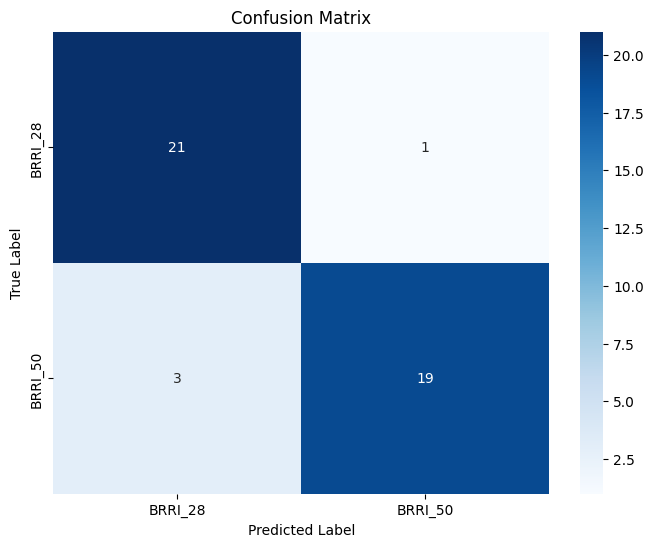

In [22]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
